# OzonMasters, "Машинное обучение 1". Домашнее задание C3 (10 баллов)

**Студент: Арешин Станислав Олегович**

1. (4 балла) Доделать все пункты ноутбука до конца

2. (2 балла) Для регрессионного дерева необходимо использовать такой критерий:
    $$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$
    
    Докажите, что минимум H(R) достигается при $c$:

    $$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

3. (2 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.

    Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.
    
    
4. (2 балла) Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing).
    Разбейте данные на обучение, контроль и тест. Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.


Бонусных баллов в этот раз нет :)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

## Задание 1 (4 балла)

**Доделать все пункты ноутбука до конца**

*Основные изменения в реализации с семинара:*

При тесте дерева регрессии на датасете california_housing была найдена проблема. При глубине дерева больше 7 начали появлятся сплиты с пустыми узлами. Я решил вывести узел до разбиения и порог разбиения для мест, где происходили такие сплиты: 

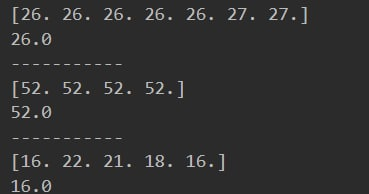

На скриншоте видно, что пустой сплит происходит в случае, если все элементы узла одинаковые, либо очень близки. В исходной реализации мы сортировали значения признака, находили лучшее значение для сплита и усредняли с предыдущим. В такой реализации есть проблема повторяющихся значений, например, в первом выводе (26 + 26) / 2 = 26, при маске >=26 получается, что все объекты уходят в правого ребёнка, левый остаётся пустым. Правильно было (26 + 27) / 2 = 26.5, тогда при маске >=26.5 получаем, что объекты, где значения признака 26 уходят в левого ребёнка, остальные в правого. Аналогичная проблема была во всех выводах узел до разбиения - порог разбиения.

Исходя из этих наблюдений я исправил функцию get_best_split в классе Criterion так, чтобы не учитывались повторяющиеся значения признака.

Осталось разобраться с проблемой, когда все значения в признаке одинаковые. Такой сплит не имеет смысла и будет только приводить к появлению пустых узлов. Чтобы исправить эту проблему, я добавил условие в функцию get_best_split  в классе TreeNode, чтобы для сплита не рассматривались признаки, значения которых одинаковые (кажется это логично).

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = \sum_{k=1}^K p_k (1 - p_k) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

### Построение критерия и вычисление предиката

В данном пункте предлагается:
- реализовать метод `get_best_split` у абстрактного класса `Criterion`, который выполняет поиск порога разбиения $\beta$ по вектору признаков;
- для каждого из критериев `GiniCriterion`, `EntropyCriterion`, `MSECriterion` реализовать два метода:
    - `score`, считает чистоту узла, т.е. непосредственно сам критерий $H(R)$;
    - `get_predict_val`, вычисляет предсказанное значение в листе.

In [2]:
class Criterion:
    
    def get_best_split(self, feature, target):
        """
        Parameters
        ----------
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        threshold : value to split feature vector, float
        q_value   : impurity improvement, float
        """
        
        thresholds = np.sort(list(set(feature)))
        N = len(target)
        
        q_best = -np.inf
        i_best = None
        
        h_0 = self.score(target)
        
        for i, t in enumerate(thresholds[1:]):
            mask_right = (feature >= t)
            
            R_l = len(target[~mask_right])
            R_r =  len(target[mask_right])
            h_l = self.score(target[~mask_right])
            h_r = self.score(target[mask_right])
            
            q = h_0 - R_l / N * h_l - R_r / N * h_r
            if q > q_best:
                q_best = q
                i_best = i + 1 
        
        threshold = (thresholds[i_best] + thresholds[i_best - 1]) / 2
            
        return threshold, q_best
    
    
    def score(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        impurity : float
        """

        raise NotImplementedError

    def get_predict_val(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        prediction :
            - classification: probability distribution in node, np.ndarray.shape = (n_classes, )
            - regression: best constant approximation, float
        """

        raise NotImplementedError


class GiniCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes
    
    def get_predict_val(self, classes):
        pred = np.bincount(classes, minlength=self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return 1 - (pred ** 2).sum()


class EntropyCriterion(Criterion):
    EPS = 1e-6
    
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        pred = np.bincount(classes, minlength=self.n_classes) / len(classes)
        return pred

    def score(self, classes):
        pred = self.get_predict_val(classes)
        return - (pred * np.log(pred + self.EPS)).sum()


class MSECriterion(Criterion):
    def get_predict_val(self, target):
        pred = target.mean()
        return pred

    def score(self, target):
        pred = self.get_predict_val(target)
        return ((target - pred) ** 2).mean()

Проверь себя:

In [3]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
y_true = [0.2, 0.3, 0.3, 0, 0.2]
y_pred = GiniCriterion(n_classes=5).get_predict_val(target)
assert np.allclose(y_pred, y_true)

In [4]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
scores = GiniCriterion(n_classes=5).score(target)
assert np.isclose(scores, 0.74)

In [5]:
N = 100

x = np.arange(N)
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

threshold, q_best = GiniCriterion(n_classes=2).get_best_split(x, y)
assert np.isclose(threshold, 49.5)
assert np.isclose(q_best, 0.5)

### Вычисление параметров предиката и разбиение вершины дерева

Ниже вам предлагается реализовать несколько методов. Для класса `TreeNode` необходимо реализовать методы:
* `get_best_split` - вычисление оптимальных $\alpha$, $\beta$ для выбранного функционалиа $Q(R, \alpha, \beta)$;
* `split` – разбиение узла с заданными подобранными параметрами.

In [6]:
class TreeNode:
    def __init__(self, impurity, predict_val, depth):
        self.impurity = impurity        # node impurity
        self.predict_val = predict_val  # prediction of node
        self.depth = depth              # current node depth
        
        self.feature = None             # feature to split
        self.threshold = None           # threshold to split
        self.improvement = -np.inf      # node impurity improvement after split
        
        self.child_left = None
        self.child_right = None
    
    @property
    def is_terminal(self):
        return self.child_left is None and self.child_right is None
    
    @classmethod
    def get_best_split(cls, X, y, criterion):
        '''
        Finds best split for current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        
        Returns
        -------
        feature   : best feature to split,  int
        threshold : value to split feature, float
        q_value   : impurity improvement,   float
        '''

        q_best = -np.inf
        t_best = None
        f_best = None
        
        for fi in range(X.shape[1]):

            if len(np.unique(X[:, fi])) == 1:
                continue
                
            t, q = criterion.get_best_split(X[:, fi], y)
            if q > q_best:
                q_best = q
                t_best = t
                f_best = fi
                
        return f_best, t_best, q_best
    
    def get_best_split_mask(self, X):
        '''
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
        '''

        return X[:, self.feature] >= self.threshold
    
    def split(self, X, y, criterion, **split_params):
        '''
        Split current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        split_params : result of get_best_split method
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
            
        child_left  : TreeNode
        child_right : TreeNode
        '''
        
        self.feature = split_params['feature']
        self.threshold = split_params['threshold']
        self.improvement = split_params['improvement']
        
        mask_right_child = self.get_best_split_mask(X)
        self.child_left = self.from_criterion(y[~mask_right_child], criterion, self.depth + 1)
        self.child_right = self.from_criterion(y[mask_right_child], criterion, self.depth + 1)
        
        return mask_right_child, self.child_left, self.child_right
           
    @classmethod
    def from_criterion(cls, y, criterion, depth=0):
        return cls(
            impurity=criterion.score(y),
            predict_val=criterion.get_predict_val(y),
            depth=depth,
        )

Проверьте себя:

In [7]:
N, M = 100, 10
f = 3

criterion = GiniCriterion(n_classes=2)
x = np.c_[[np.arange(N) if f == fi else np.random.random(size=N) for fi in range(M)]].T
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

In [8]:
best_feature, best_threshold, improvement = TreeNode.get_best_split(x, y, criterion)

assert best_feature == f
assert best_threshold == 49.5
assert improvement == 0.5

### Реализация дерева.

Вот мы и добрались до самого важного. В классе `DecisionTree` вам необходимо реализовать следующие методы:
* fit - обучения дерева
* predict - выдача предсказаний по дереву

Дерево предлагается строить самым простым способом – рекурсивно. Для реализации предлагается использовать два вспомогательных метода: 
* `_build_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_nodes_predictions` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет матрицу предсказаний.

Важный вопрос при реализации: как выбрать критерий останова создания новой вершины?

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`;
* если в вершине меньше, чем `min_leaf_size` объектов;
* если в вершине все объекты имеют одинаковые метки;
* если функционал качества не увеличивается больше, чем на `min_improvement`.

Также для интерпретации важности признаков, участвующих в построении дерева, предлагается реализовать метод-свойство `feature_importances_`.

In [9]:
from collections import deque


class DecisionTree:
    def __init__(self, max_depth=None, min_leaf_size=None, min_improvement=None):
        self.criterion = None
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_improvement = min_improvement

    def _build_nodes(self, X, y, criterion, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
              
        if self.max_depth is not None and node.depth >= self.max_depth:
            return
        
        if self.min_leaf_size is not None and self.min_leaf_size > len(indices):
            return
        
        if np.unique(y[indices]).shape[0] <= 1:
            return
        
        X_node, y_node = X[indices], y[indices]
        feature, threshold, improvement = node.get_best_split(X_node, y_node, criterion)
        
        if self.min_improvement is not None and self.min_improvement > improvement:
            return
        
        mask_right, child_left, child_right = node.split(
            X_node, y_node, criterion,
            feature = feature,
            threshold = threshold,
            improvement = improvement
        )
        
        self._build_nodes(X,y, criterion, indices[~mask_right], child_left)
        self._build_nodes(X,y, criterion, indices[mask_right], child_right)
        
    def _get_nodes_predictions(self, X, predictions, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to be feild,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
        if node.is_terminal:
            predictions[indices] = node.predict_val
        else:
            mask_right = node.get_best_split_mask(X[indices])
            self._get_nodes_predictions(X, predictions, indices[~mask_right], node.child_left)
            self._get_nodes_predictions(X, predictions, indices[mask_right], node.child_right)
        
    
    @property
    def feature_importances_(self):
        '''
        Returns
        -------
        importance : cummulative improvement per feature, np.ndarray.shape = (n_features, )
        '''
        importance = np.zeros(self.n_features_)
        
        queue = deque()
        queue.append(self.root_)
        
        while len(queue):
            node = queue.popleft()
            if node.is_terminal:
                continue
            importance[node.feature] += node.improvement
            queue.append(node.child_left)
            queue.append(node.child_right)
            
        return importance

А теперь на основе реализованного в общем виде дерева, сделаем дерево для классификации:

In [10]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('gini', 'entropy', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'gini':
            criterion = GiniCriterion(n_classes=self.n_classes_)
        elif self.criterion == 'entropy':
            criterion = EntropyCriterion(n_classes=self.n_classes_)
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes_))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

Проверь себя:

In [11]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [12]:
some_X.shape, some_y.shape, predictions.shape

((400, 2), (400,), (400,))

In [13]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [14]:
assert (some_tree.feature_importances_ == [0.25, 1.  ]).all()

Ещё одна проверка:

In [17]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [18]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

### Визуализация результатов

Давайте проверим, что дерево работает на нескольких модельных задачах.

In [19]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

Функция для визуализации двумерной выборки:

In [20]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

Функция для визуализации работы дерева на двумерной выборке:

In [21]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

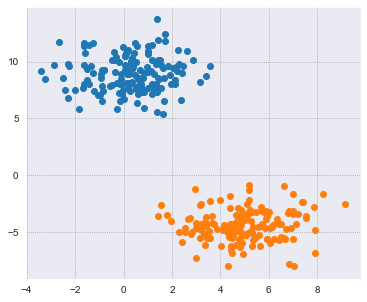

In [22]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

Accuracy = 1.0


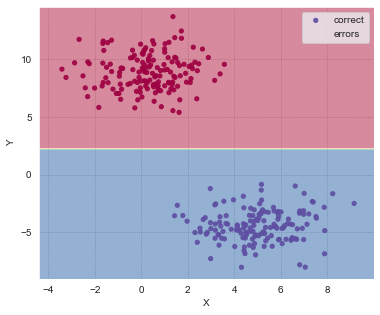

In [23]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

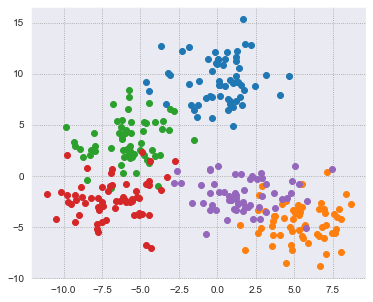

In [24]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

Accuracy = 0.4


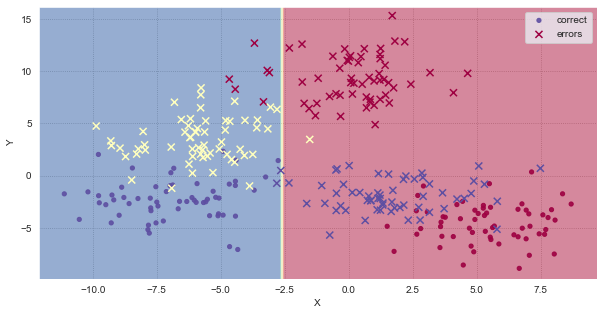

In [25]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.7466666666666667


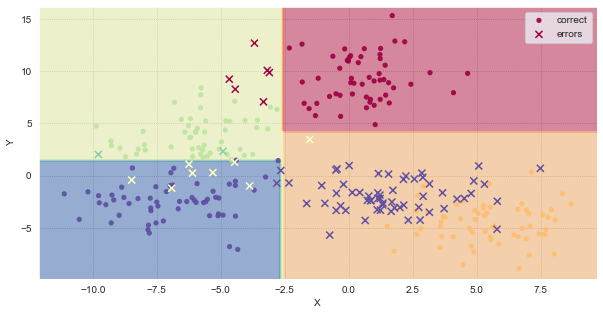

In [26]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.89


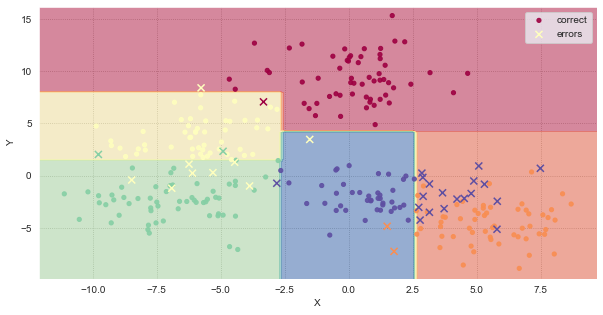

In [27]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.94


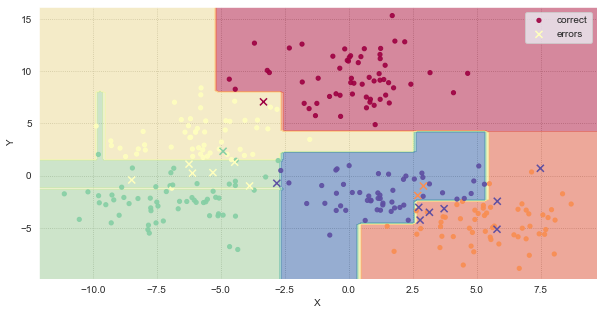

In [28]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


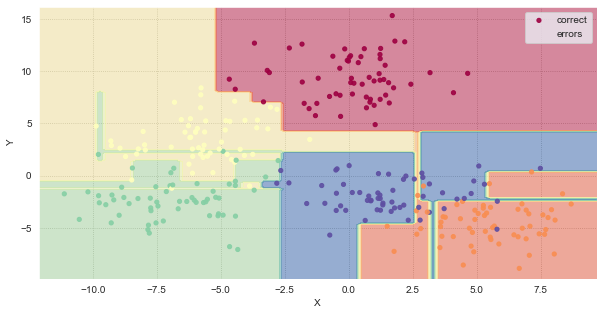

In [29]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

Accuracy = 0.95


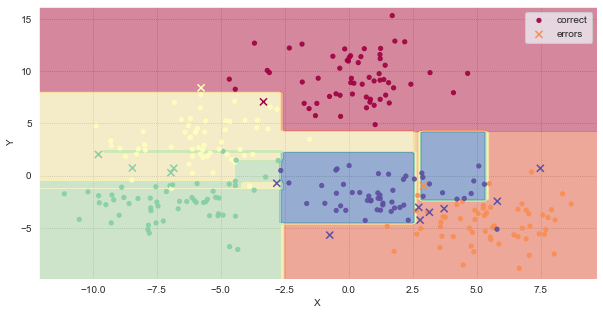

In [30]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.92


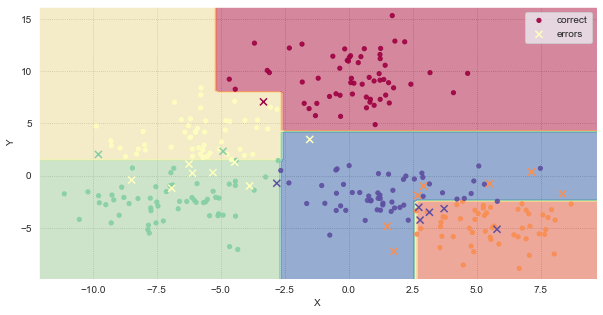

In [31]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.08)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

## Задание 2 (2 балла)

Для регрессионного дерева необходимо использовать такой критерий:

$$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$
    
**Докажите, что минимум H(R) достигается при $c$:**

$$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

**Доказательство**

$$H(R) =  \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2 = M[(y - c)^2] $$

Тогда, используя свойство линейности математического ожидания, и то, что математическое ожидание константы равно константе, получаем:

$$M[(y - c)^2] = M[(y^2 - 2yc + c^2)] = M[y^2] - 2cM[y] + c^2 $$

Вычислим частную производную функционала $H(R)$ по $c$ и приравняем её к нулю:

$$\frac{\partial{H(R)}}{\partial{c}}  = \frac{\partial{(M[y^2] - 2cM[y] + c^2)}}{\partial{c}} = 0$$

Тогда:

$$\frac{\partial{(M[y^2] - 2cM[y] + c^2)}}{\partial{c}} = 0 \Leftrightarrow 0 - 2M[y] + 2c = 0 \Leftrightarrow$$

$$\Leftrightarrow 2c = 2M[y] \Leftrightarrow c = M[y] = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

То есть: 

$$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2 = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i -  \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j)^2$$

Что и требовалось доказать.

## Задание 3 (2 балла)

**Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.**

**Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.**

### Реализация 

Реализация критерия MSE находится в пункте 1. Ниже представлена реализация класса дерева решений для задачи регрессии.

In [32]:
class RegressionDecisionTree(DecisionTree):
    def __init__(self, criterion='MSE', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('MSE'):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'MSE':
            criterion = MSECriterion()
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        preds = np.zeros(shape=(X.shape[0]))
        self._get_nodes_predictions(X, preds, np.arange(X.shape[0]), self.root_)
        return preds

### Модельный пример регрессии

Для оценивания качества регрессии я выбрал следующие метрики: r2_score, mean_squared_error, mean_absolute_error. Данные генирируются с помощью sklearn.datasets.make_regression.

In [58]:
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [59]:
def plot_regression_result(model, X, y, preds):
    preds = model.predict(X)
    plt.figure(figsize=(14,7))
    plt.title(f'Regression Tree result with max_depth = {model.max_depth}, min_leaf_size = {model.min_leaf_size}, min_improvement = {model.min_improvement}')
    sns.scatterplot(x = X.reshape(-1), y = y.reshape(-1), label = 'Data')
    sort_ind = np.argsort(X, axis = 0)
    sns.lineplot(x = X[sort_ind, 0].reshape(-1), y = preds[sort_ind].reshape(-1), color = 'r', label = 'Regression')
    plt.xlabel('feauture')
    plt.ylabel('target')
    plt.show()

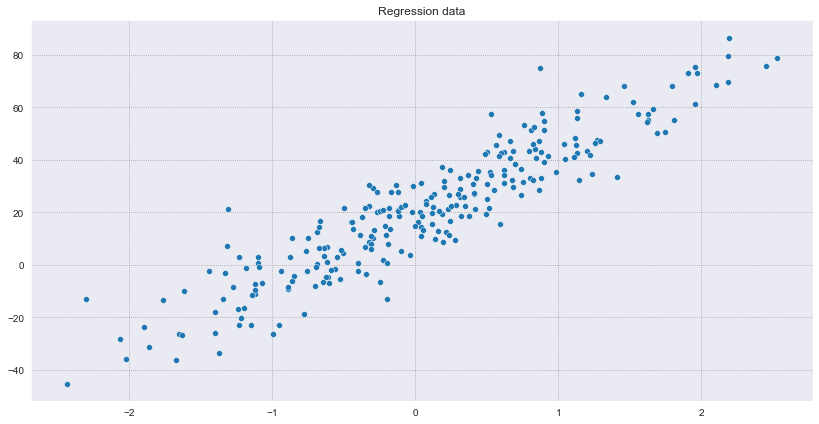

In [60]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples= 250, n_features=1, bias=19, noise=10, random_state=1)

plt.figure(figsize=(14,7))
plt.title('Regression data')
sns.scatterplot(x = X.reshape(-1), y= y.reshape(-1))
plt.show()

Начнём с решающего пня:

R_2 score of the model: 0.5751095234452059
MSE of the model: 271.3240942609108
MAE of the model: 13.350557289679932


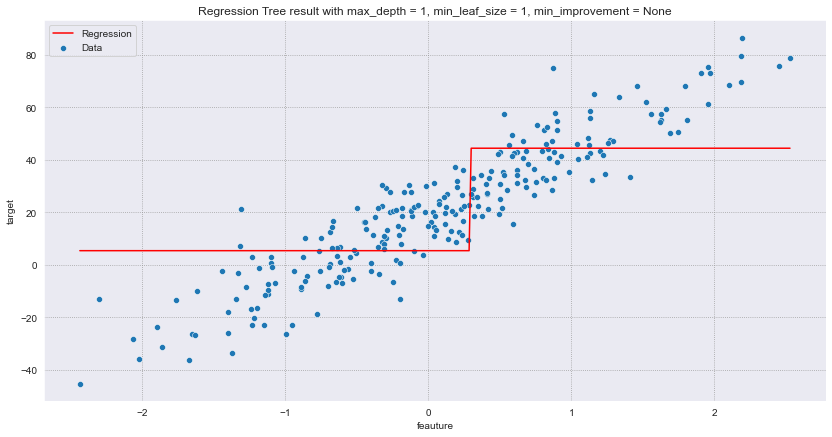

In [61]:
model = RegressionDecisionTree(max_depth=1, min_leaf_size=1)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Решающий пень, как и ожидалось, показывает неудовлетворительные результаты по всем выбранным метрикам качества, увеличим глубину дерева до 2, mean_leaf_size пока оставляем прежним.

R_2 score of the model: 0.7914700874239182
MSE of the model: 133.16182117043945
MAE of the model: 9.23444068213776


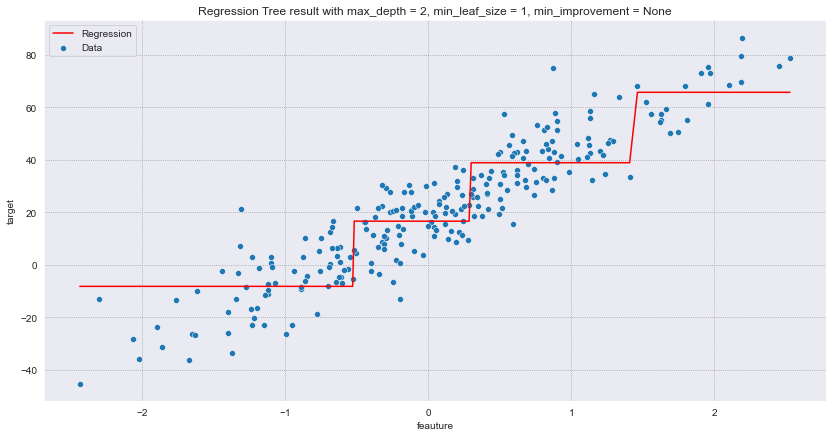

In [62]:
model = RegressionDecisionTree(max_depth=2, min_leaf_size=1)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Результат дерева глубины 2 значительно лучше по всем метрика, переобучения под данные пока незаметно, продолжаем увеличивать глубину, теперь возьмем 3.

R_2 score of the model: 0.8630236173358752
MSE of the model: 87.46958336847251
MAE of the model: 7.293318028555538


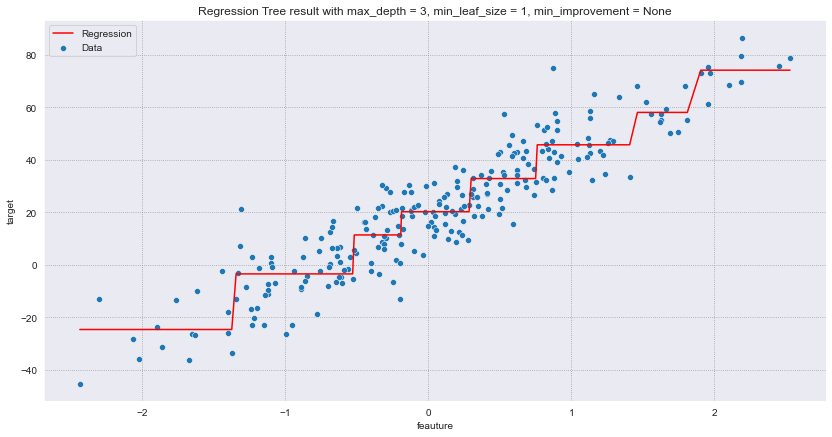

In [63]:
model = RegressionDecisionTree(max_depth=3, min_leaf_size=1)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Снова метрики качества улучшились, переобучения под данные визуально незаметно, увеличим глубину до 5.

R_2 score of the model: 0.9007450285679842
MSE of the model: 63.38166353608851
MAE of the model: 6.18510889918914


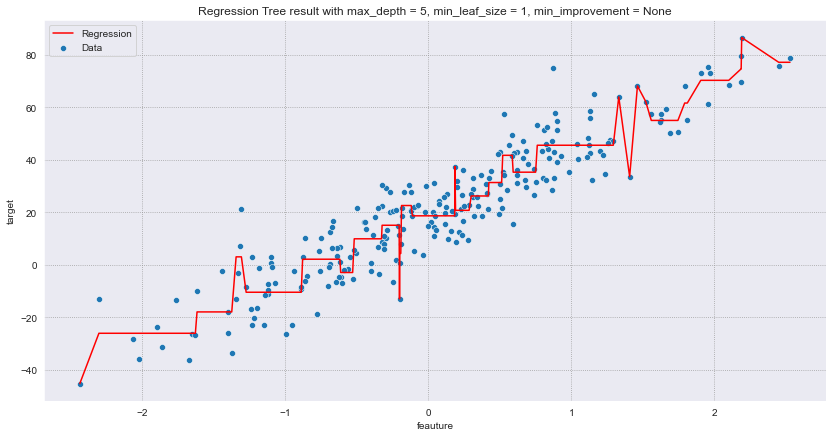

In [64]:
model = RegressionDecisionTree(max_depth=5, min_leaf_size=1)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

При глубине дерева 5 метрики качества улучшились, но не так сильно. Кроме того заметно, что алгоритм начал немного переобучаться под данные, (есть странные скачки в направление удалённых точек). Теперь посмотрим на дерево глубины 10.

R_2 score of the model: 0.9840074386787449
MSE of the model: 10.21243698043217
MAE of the model: 1.4622106381507893


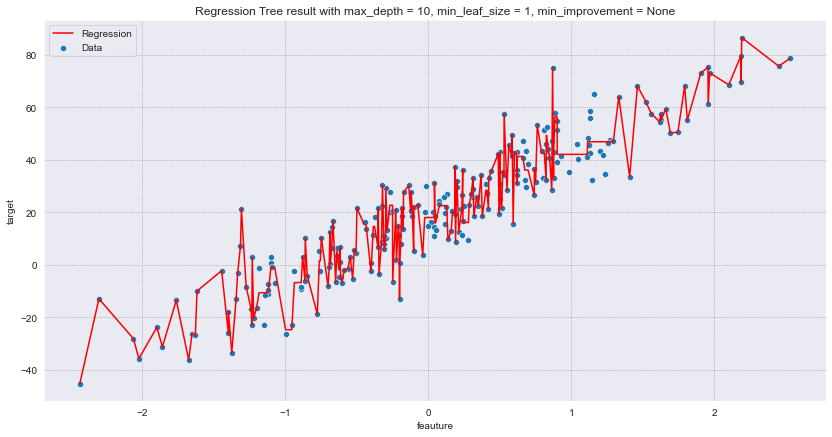

In [65]:
model = RegressionDecisionTree(max_depth=10, min_leaf_size=1)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

У дерева глубины 10 уже очень хорошие результаты по метрикам на обучающей выборке, но в данном случае дерево очень сильно переобучилось, что плохо. Предлагаю взять дерево глубины 10 и попробовать ограничить сложность параметрами min_leaf_size и min_improvement. Для начала установим min_leaf_size=10.

R_2 score of the model: 0.9280962503597199
MSE of the model: 45.915879083245024
MAE of the model: 5.211881186571631


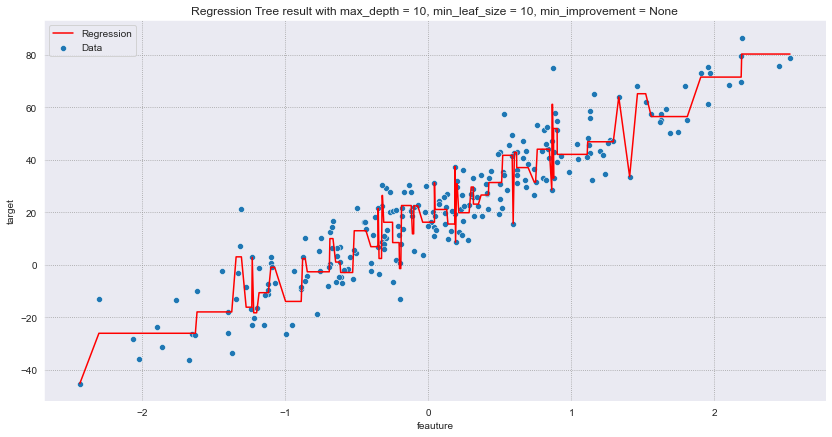

In [66]:
model = RegressionDecisionTree(max_depth=10, min_leaf_size=10)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Результат по метрикам второй после обычного дерева глубины 10. Признаков переобучения стало меньше, но все равно кажется, что дерево глубины 5 показало чуть лучше результат в этом плане (хотя скор немного меньше). Попробуем min_leaf_size = 15.

R_2 score of the model: 0.9108773549856685
MSE of the model: 56.911421344911616
MAE of the model: 6.052444810302573


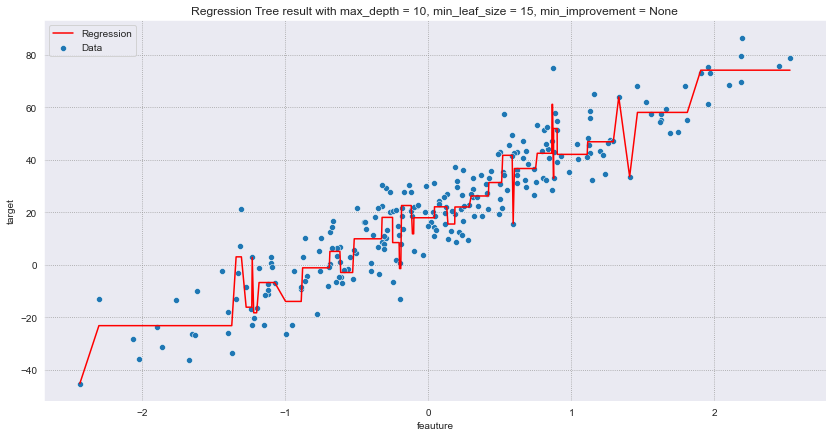

In [67]:
model = RegressionDecisionTree(max_depth=10, min_leaf_size=15)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Качество на обучении стало чуть-чуть хуже, зато ещё меньше признаков переобучения. Пока этот результат примерно наравне с деревом глубины 5. Ещё увеличим min_leaf_size до 20.

R_2 score of the model: 0.900502268009124
MSE of the model: 63.53668416467282
MAE of the model: 6.319603693929239


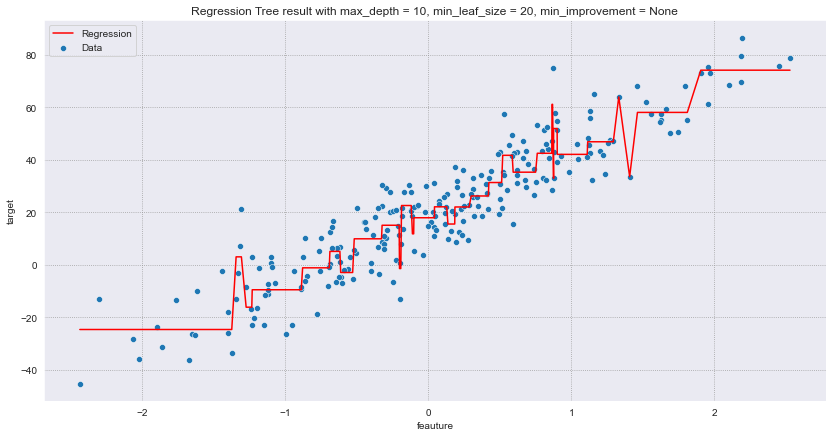

In [68]:
model = RegressionDecisionTree(max_depth=10, min_leaf_size=20)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Качество на обучении ещё немного ухудшилось, теперь наравне с деревом глубины 5, однако,визуально результат выглядит лучше. Пожалуй, пока это лучший результат. Попробуем теперь пару вариантов ограничения сложности с помощью min_improvement. Начнем с min_improvement = 5, глубина так же 10.

R_2 score of the model: 0.9405313659083375
MSE of the model: 37.97513517527151
MAE of the model: 3.961883728857677


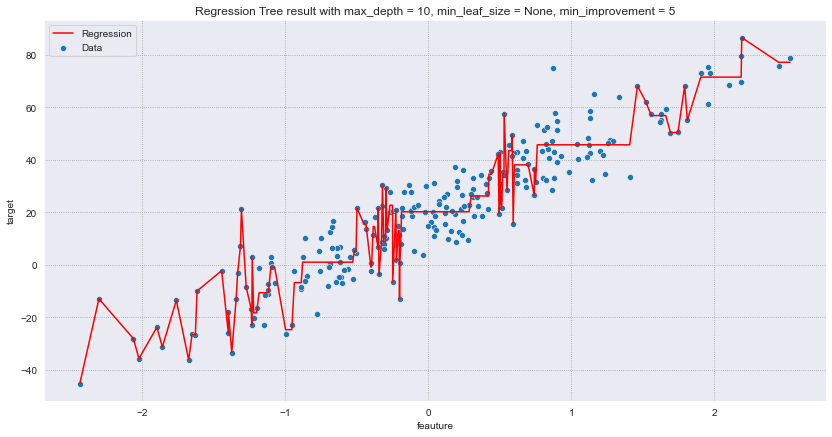

In [74]:
model = RegressionDecisionTree(max_depth=10,  min_improvement=5)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Пока плохо. Несмотря на приемлемый скор, очень большое переобучение. Увеличим min_improvement до 10.

R_2 score of the model: 0.8997183808649126
MSE of the model: 64.03725426718601
MAE of the model: 6.068181088222685


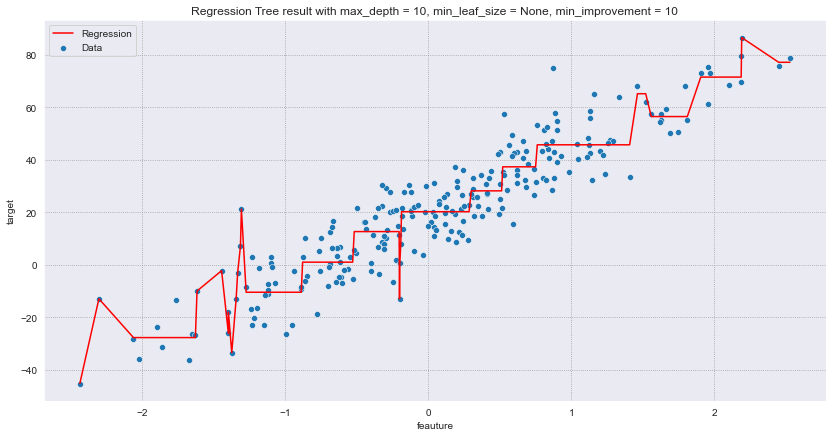

In [79]:
model = RegressionDecisionTree(max_depth=10,  min_improvement=10)
model.fit(X, y)
preds = model.predict(X)
print(f'R_2 score of the model: {r2_score(y, preds)}')
print(f'MSE of the model: {mean_squared_error(y, preds)}')
print(f'MAE of the model: {mean_absolute_error(y, preds)}')

plot_regression_result(model, X, y, preds)

Скор приблизительно такой же, как при  min_leaf_size=20, однако тот результат мне нравится больше.

Подведем итоги. Для деревьев решений очень важно ограничивать сложность алгоритма с помощью критериев останова: максимальная глубина, минимальное кол-во элементов в листе, минимальное приращение критерия информативности, так как иначе они сильно переобучаются даже на модельных примерах, не говоря уже о реальных задачах.

## Задание 4 (2 балла)

**Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing). Разбейте данные на обучение, контроль и тест. Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.**

### Загрузка данных

In [43]:
from sklearn.datasets import fetch_california_housing

df, target = fetch_california_housing(return_X_y=True, as_frame=True)

In [44]:
print(df.shape)
df.head()

(20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [46]:
print(target.shape)
target.head()

(20640,)


0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [47]:
X = np.array(df)
y = np.array(target)

X.shape, y.shape

((20640, 8), (20640,))

### Train-val-test split

In [48]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y, val_size=0.15, test_size=0.15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    return  X_train, X_val, X_test, y_train, y_val, y_test

In [49]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, val_size=0.15, test_size=0.15)

print('Train shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_val.shape, y_val.shape)
print('Test shape: ', X_test.shape, y_test.shape)

Train shape:  (14448, 8) (14448,)
Validation shape:  (3096, 8) (3096,)
Test shape:  (3096, 8) (3096,)


### Подбор гиперпараметров на отложенной выборке

Глубокие деревья строятся довольно долго, чтобы не перебирать большое кол-во комбинаций параметров, переберем сначала пары  max_depth и min_leaf_size, а затем у лучшего набора попробуем дополнительно ограничить сложность, настроив min_improvement. В качестве метрики для оценивания результата регрессии я выбрал r2_score.

In [50]:
from sklearn.metrics import r2_score
from tqdm import tqdm

In [51]:
max_depth_grid = [3, 5, 7, 9, 11]
min_leaf_size_grid = [3, 5, 7, 9, 11, 13]

res_r2_score = {}

for max_depth in tqdm(max_depth_grid):
    for min_leaf_size in min_leaf_size_grid:
        model = RegressionDecisionTree(
                    max_depth=max_depth,
                    min_leaf_size=min_leaf_size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        res_r2_score[(max_depth, min_leaf_size)] = r2_score(y_val, y_pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [25:46<00:00, 309.23s/it]


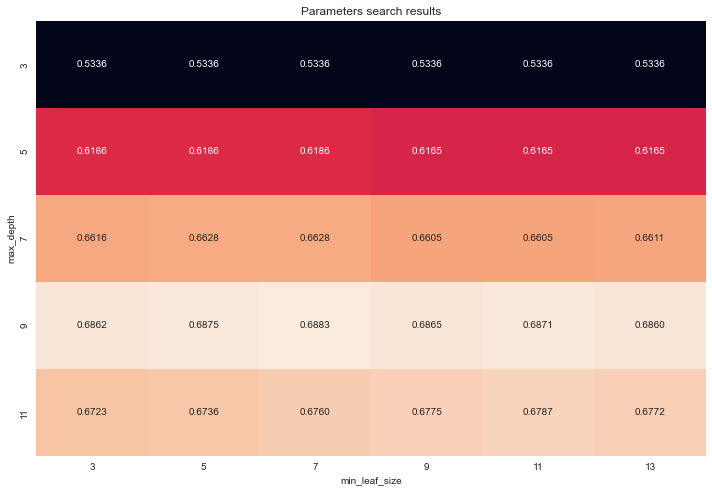

In [54]:
score = np.array(list(res_r2_score.values())).reshape(len(max_depth_grid), len(min_leaf_size_grid))

plt.figure(figsize=(12,8))
plt.title('Parameters search results')
sns.heatmap(score, cbar=False, annot=True, fmt= '.4f',
            yticklabels=max_depth_grid, xticklabels=min_leaf_size_grid)
plt.xlabel('min_leaf_size')
plt.ylabel('max_depth')
plt.show()

In [55]:
best_params = max(res_r2_score,  key=res_r2_score.get)
print(f'The best r2_score is {res_r2_score[best_params]} with params {best_params}')

The best r2_score is 0.6883181280000473 with params (9, 7)


Если сравнить результаты r2_score в двумерной сетке по глубине деревьев, видно что при max_depth = 9 при всех значениях min_leaf_size получается лучший результат относительно других значений глубины. Конкретно самый лучший результат при min_leaf_size = 7. Предлагаю зафиксировать параметр глубины 9 и дополнительно перебрать по стеке min_leaf_size и min_improvement с целью улучшения результата.

Пока также запомим лучший результат:

* max max_depth=9, min_leaf_size=7, r2_score = 0.6883

In [51]:
max_depth = 9
min_leaf_size_grid = [3, 5, 7, 9, 11, 13, 15]
min_improvement_grid = [0.001, 0.0025, 0.005, 0.01, 0.025]

res_r2_score = {}

for min_leaf_size in tqdm(min_leaf_size_grid):
    for min_improvement in min_improvement_grid:
        model = RegressionDecisionTree(
                    max_depth=max_depth,
                    min_leaf_size=min_leaf_size,
                    min_improvement=min_improvement)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        res_r2_score[(min_leaf_size, min_improvement)] = r2_score(y_val, y_pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [35:42<00:00, 306.08s/it]


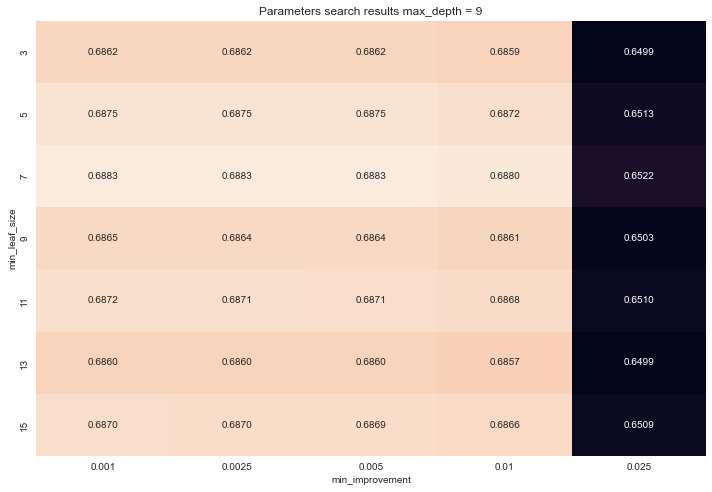

In [52]:
score = np.array(list(res_r2_score.values())).reshape(len(min_leaf_size_grid), len(min_improvement_grid))

plt.figure(figsize=(12,8))
plt.title(f'Parameters search results max_depth = {max_depth}')
sns.heatmap(score, cbar=False, annot=True, fmt= '.4f',
            yticklabels=min_leaf_size_grid, xticklabels=min_improvement_grid)
plt.xlabel('min_improvement')
plt.ylabel('min_leaf_size')
plt.show()

In [53]:
best_params = max(res_r2_score,  key=res_r2_score.get)
print(f'The best r2_score is {res_r2_score[best_params]} with params {best_params}')

The best r2_score is 0.6883185896232484 with params (7, 0.001)


Значительно увеличить точность не получилось (только в 6-ом знаке) и это при минимальном min_improvement, похоже при такой глубине дополнительные ограничения на сложность не имеют смысла. Поэтому на всякий случай (а вдруг будет лучше), попробуем перебрать дополнительные ограничения при глубине 11. Посмотрим, что получится.

In [54]:
max_depth = 11
min_leaf_size_grid = [3, 5, 7, 9, 11]
min_improvement_grid = [0.001, 0.005, 0.01, 0.025]

res_r2_score = {}

for min_leaf_size in tqdm(min_leaf_size_grid):
    for min_improvement in min_improvement_grid:
        model = RegressionDecisionTree(
                    max_depth=max_depth,
                    min_leaf_size=min_leaf_size,
                    min_improvement=min_improvement)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        res_r2_score[(min_leaf_size, min_improvement)] = r2_score(y_val, y_pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [24:00<00:00, 288.04s/it]


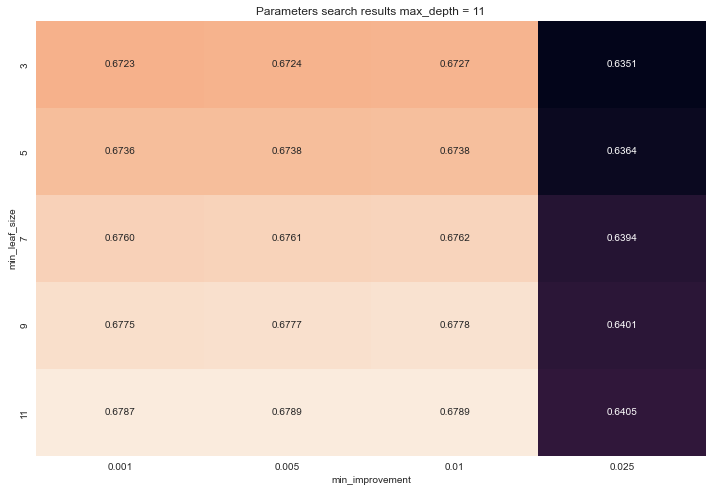

In [55]:
score = np.array(list(res_r2_score.values())).reshape(len(min_leaf_size_grid), len(min_improvement_grid))

plt.figure(figsize=(12,8))
plt.title(f'Parameters search results max_depth = {max_depth}')
sns.heatmap(score, cbar=False, annot=True, fmt= '.4f',
            yticklabels=min_leaf_size_grid, xticklabels=min_improvement_grid)
plt.xlabel('min_improvement')
plt.ylabel('min_leaf_size')
plt.show()

In [56]:
best_params = max(res_r2_score,  key=res_r2_score.get)
print(f'The best r2_score is {res_r2_score[best_params]} with params {best_params}')

The best r2_score is 0.6789071580851027 with params (11, 0.01)


Увы, результата лучше не получилось, все комбинации проигрывают предыдущей лучшей уже во втором знаке. Итого, обозначим лучшими параметрами алгоритм:

* max max_depth=9, min_leaf_size=7, min_improvement=0.001, r2_score = 0.6883


### Результат на тесте

Протестируем алгоритм с лучшими параметрами на тестовой выборке.

In [57]:
model = RegressionDecisionTree(
                    max_depth=9,
                    min_leaf_size=7,
                    min_improvement=0.001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Result Test set r2_score: {r2_score(y_test, y_pred)}')

Result Test set r2_score: 0.68079172988439


Получен приблизительно такой же скор, что и на владационном датасете. Это говорит об отсутствии переобучения, так как параметры настраивались на валидационной выборке, независимо от теста. Отметим, что качество деревьев регрессии для этой задачи в целом не очень высокое.  Видно, что слишком глубокие деревья строить смысла нет, так как они начинают переобучаться под данные, аналогично нет смысла строить деревья маленькой глубины, в этом случае видно недообучение. Необходимо грамотно подбирать параметры ограничения сложности решающих деревьев, чтобы попасть в "золотую середину", когда алгоритм хорошо обучен.